# Convolutional Neural Network Playing Card Classifier


### The task is to classify every picture in the test set into 53 different classes. At the end the accuracy(95%) of the model on this set is visualized.(Accuracy = Correct/Total).

In [1]:
pip install timer

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import timer
from timeit import default_timer as timer
import pandas as pd
from tqdm.auto import tqdm
from google.colab import files
from torchsummary import summary

### To load the Kaggle Card dataset, you have to log into Kaggle and download API token from Settings -> Create New Token. This will download the kaggle.json file, which has to be uploaded in the next code cell.

In [3]:
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d gpiosenka/cards-image-datasetclassification
! unzip cards-image-datasetclassification.zip -d cards-image-datasetclassification

Number of ace of clubs train examples:
121
Image size:
(224, 224)


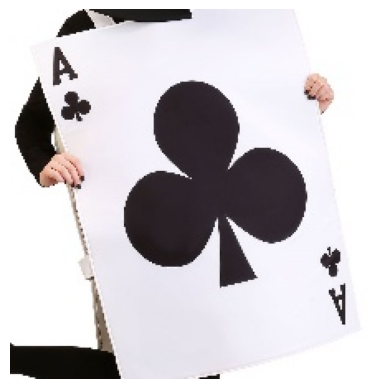

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/content/cards-image-datasetclassification/train/ace of clubs/001.jpg")
print('Number of ace of clubs train examples:')
!cd '/content/cards-image-datasetclassification/train/ace of clubs/' && (ls -lh | wc -l)
print('Image size:')
print(img.size)
plt.imshow(img)
plt.axis('off')
plt.show()

In [6]:
df = pd.read_csv("/content/cards-image-datasetclassification/cards.csv")

#Error in dataset - FileNotFoundError: [Errno 2] No such file or directory: 'cards-image-datasetclassification/train/ace of clubs/output'
df = df[df['filepaths'].str.contains('.jpg')] #Extract only the images

df.head()

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


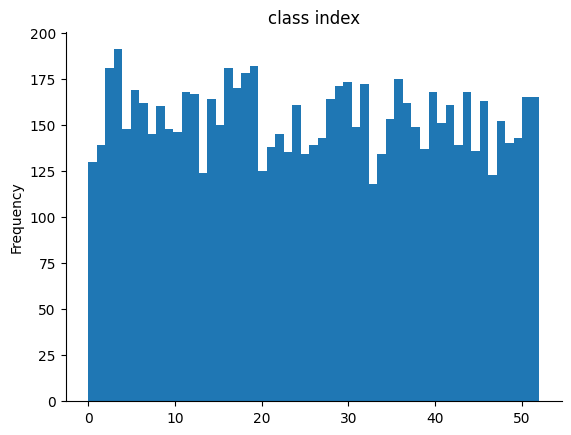

In [7]:
# @title class index

from matplotlib import pyplot as plt
df['class index'].plot(kind='hist', bins=53, title='class index')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [8]:
df[df["data set"] == "train"].shape, df[df["data set"] == "valid"].shape, df[df["data set"] == "test"].shape,

((7624, 5), (265, 5), (265, 5))

In [9]:
df["labels"].unique()

array(['ace of clubs', 'ace of diamonds', 'ace of hearts',
       'ace of spades', 'eight of clubs', 'eight of diamonds',
       'eight of hearts', 'eight of spades', 'five of clubs',
       'five of diamonds', 'five of hearts', 'five of spades',
       'four of clubs', 'four of diamonds', 'four of hearts',
       'four of spades', 'jack of clubs', 'jack of diamonds',
       'jack of hearts', 'jack of spades', 'joker', 'king of clubs',
       'king of diamonds', 'king of hearts', 'king of spades',
       'nine of clubs', 'nine of diamonds', 'nine of hearts',
       'nine of spades', 'queen of clubs', 'queen of diamonds',
       'queen of hearts', 'queen of spades', 'seven of clubs',
       'seven of diamonds', 'seven of hearts', 'seven of spades',
       'six of clubs', 'six of diamonds', 'six of hearts',
       'six of spades', 'ten of clubs', 'ten of diamonds',
       'ten of hearts', 'ten of spades', 'three of clubs',
       'three of diamonds', 'three of hearts', 'three of spades',

In [10]:
#defining some parameters and constants
BATCH_SIZE = 8
LEARNING_RATE = 0.0035
EPOCHS = 50
LINEAR_LAYER_DROPOUT = 0.35

torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [11]:
#Dataset impl to help use DataLoader with Pandas DataFrame
class MyDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
  def __len__(self):
    return len(self.dataframe)
  def __getitem__(self, index):
        image_path = "./cards-image-datasetclassification/" + self.dataframe.iloc[index, 1]
        label = self.dataframe.iloc[index, 0]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [12]:
#Apply some transforms to training data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.25),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
#create datasets
train_dataset = MyDataset(dataframe=df[df["data set"] == "train"], transform=transform)
test_dataset  = MyDataset(dataframe=df[df["data set"] == "test"],  transform=transform)
val_dataset = MyDataset(dataframe=df[df["data set"] == "valid"], transform=transform)


# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 953 batches of 8
Length of test dataloader: 34 batches of 8
Length of val dataloader: 34 batches of 8


In [14]:
# Try deeper network with residual connections

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class BottleneckResidualLayer(nn.Module):
    def __init__(self, in_channels, mid_channels):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
            nn.Conv2d(mid_channels, in_channels, kernel_size=1),
            nn.BatchNorm2d(in_channels),
        )
        self.relu = nn.ReLU()
        self.se = SEBlock(in_channels)

    def forward(self, x):
        identity = x
        out = self.layer(x)
        out = self.se(out)
        return self.relu(out + identity)

class ConvLayer(nn.Module):
  def __init__(self, in_channels, out_channels, maxpool=2):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.MaxPool2d(maxpool),
        nn.ReLU()
    )
  def forward(self, x):
    return self.layer(x)

class ResidualCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            #3x224x224
            ConvLayer(in_channels=3, out_channels=16),
            #16x112x112
            BottleneckResidualLayer(in_channels=16, mid_channels=32),
            BottleneckResidualLayer(in_channels=16, mid_channels=32),
            ConvLayer(in_channels=16, out_channels=32),
            #32x56x56
            BottleneckResidualLayer(in_channels=32, mid_channels=64),
            BottleneckResidualLayer(in_channels=32, mid_channels=64),
            ConvLayer(in_channels=32, out_channels=64),
            #64x28x28
            BottleneckResidualLayer(in_channels=64, mid_channels=128),
            BottleneckResidualLayer(in_channels=64, mid_channels=128),
            ConvLayer(in_channels=64, out_channels=128),
            #128x14x14
            BottleneckResidualLayer(in_channels=128, mid_channels=256),
            BottleneckResidualLayer(in_channels=128, mid_channels=256),
            ConvLayer(in_channels=128, out_channels=256),
            #256x7x7
            BottleneckResidualLayer(in_channels=256, mid_channels=512),
            ConvLayer(in_channels=256, out_channels=512),
            #512x3x3
        )
        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(LINEAR_LAYER_DROPOUT),
            nn.Linear(in_features=512*3*3, out_features=512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(LINEAR_LAYER_DROPOUT),
            nn.Linear(in_features=512, out_features=256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(LINEAR_LAYER_DROPOUT),
            nn.Linear(in_features=256, out_features=53)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.linear_layers(x)
        return x


In [15]:
model = ResidualCNN().to(device)
summary(model,(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
         MaxPool2d-3         [-1, 16, 112, 112]               0
              ReLU-4         [-1, 16, 112, 112]               0
         ConvLayer-5         [-1, 16, 112, 112]               0
            Conv2d-6         [-1, 32, 112, 112]             544
       BatchNorm2d-7         [-1, 32, 112, 112]              64
              ReLU-8         [-1, 32, 112, 112]               0
            Conv2d-9         [-1, 32, 112, 112]           9,248
      BatchNorm2d-10         [-1, 32, 112, 112]              64
             ReLU-11         [-1, 32, 112, 112]               0
           Conv2d-12         [-1, 16, 112, 112]             528
      BatchNorm2d-13         [-1, 16, 112, 112]              32
AdaptiveAvgPool2d-14             [-1, 1

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

In [17]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [18]:
def train_step(model, data_loader, loss_fn, optimizer, device):

    model.train()

    train_loss, train_acc = 0, 0

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    return train_loss / len(data_loader), train_acc / len(data_loader)


def test_step(model, data_loader, loss_fn, device):

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    return test_loss / len(data_loader), test_acc / len(data_loader)

def train(model,
          train_data_loader,
          test_data_loader,
          optimizer,
          loss_fn,
          epochs,
          device):

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
        }

    model.to(device)

    max_accuracy = 0
    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_data_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        end_time = timer()

        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_data_loader,
            loss_fn=loss_fn,
            device=device,
        )

        if test_acc > 80 and test_acc > max_accuracy:
          max_accuracy = test_acc
          torch.save(model, "/content/drive/MyDrive/Colab Notebooks/myModel.pth")

        if test_acc >= 99:
          break

        scheduler.step()

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"time: {(end_time-start_time):.4f}"
        )

    return results


In [19]:
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

In [20]:
from google.colab import drive
drive.mount('/content/drive')
!file '/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/: directory


In [21]:
#model2 - less parameters and a little bit better result
results = train(
    model=model,
    train_data_loader=train_dataloader,
    test_data_loader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    device=device,
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6194 | train_acc: 8.4601 | test_loss: 2.5100 | test_acc: 27.9412 | time: 70.3319
Epoch: 2 | train_loss: 2.7173 | train_acc: 22.7046 | test_loss: 1.9744 | test_acc: 29.4118 | time: 68.7373
Epoch: 3 | train_loss: 2.2418 | train_acc: 36.0834 | test_loss: 1.2153 | test_acc: 64.7059 | time: 68.3612
Epoch: 4 | train_loss: 1.7691 | train_acc: 51.4953 | test_loss: 0.8705 | test_acc: 75.7353 | time: 68.4300
Epoch: 5 | train_loss: 1.4718 | train_acc: 59.1684 | test_loss: 0.5662 | test_acc: 84.9265 | time: 67.9759
Epoch: 6 | train_loss: 1.2731 | train_acc: 64.7560 | test_loss: 0.4709 | test_acc: 88.9706 | time: 68.8652
Epoch: 7 | train_loss: 1.0983 | train_acc: 69.6091 | test_loss: 0.3687 | test_acc: 91.5441 | time: 69.1427
Epoch: 8 | train_loss: 0.9549 | train_acc: 73.5178 | test_loss: 0.3858 | test_acc: 89.3382 | time: 68.2854
Epoch: 9 | train_loss: 0.8548 | train_acc: 75.8657 | test_loss: 0.2679 | test_acc: 93.0147 | time: 68.9257
Epoch: 10 | train_loss: 0.7658 | train

In [25]:
# 99% accuracy is achieved, forgot to break AFTER print in the train function :(

In [29]:
#Lets see if I can hit 100%
def train(model,
          train_data_loader,
          test_data_loader,
          optimizer,
          loss_fn,
          epochs,
          device):

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
        }

    model.to(device)

    max_accuracy = 0
    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_data_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        end_time = timer()

        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_data_loader,
            loss_fn=loss_fn,
            device=device,
        )

        scheduler.step()

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"time: {(end_time-start_time):.4f}"
        )

        if test_acc >= 100:
          print("100% accuracy achieved")
          torch.save(model, "/content/drive/MyDrive/Colab Notebooks/100percent.pth")
          break

    return results

results = train(
    model=model,
    train_data_loader=train_dataloader,
    test_data_loader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    device=device,
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1322 | train_acc: 96.1700 | test_loss: 0.0572 | test_acc: 98.1618 | time: 67.6959
Epoch: 2 | train_loss: 0.1374 | train_acc: 95.9470 | test_loss: 0.0427 | test_acc: 98.8971 | time: 69.2282
Epoch: 3 | train_loss: 0.1300 | train_acc: 96.1700 | test_loss: 0.0424 | test_acc: 98.1618 | time: 67.9997
Epoch: 4 | train_loss: 0.1362 | train_acc: 95.8158 | test_loss: 0.0335 | test_acc: 98.8971 | time: 67.3973
Epoch: 5 | train_loss: 0.1284 | train_acc: 96.2749 | test_loss: 0.0416 | test_acc: 98.1618 | time: 68.7347
Epoch: 6 | train_loss: 0.1246 | train_acc: 96.4979 | test_loss: 0.0247 | test_acc: 98.8971 | time: 67.5556
Epoch: 7 | train_loss: 0.1063 | train_acc: 96.7602 | test_loss: 0.0677 | test_acc: 97.4265 | time: 67.0630
Epoch: 8 | train_loss: 0.1155 | train_acc: 96.6291 | test_loss: 0.0382 | test_acc: 99.2647 | time: 68.8647
Epoch: 9 | train_loss: 0.1142 | train_acc: 96.8520 | test_loss: 0.0355 | test_acc: 99.2647 | time: 68.5280
Epoch: 10 | train_loss: 0.1124 | trai

In [ ]:
# 100% accuracy!!